In [1]:
import numpy as np
print("numpy version:", np.__version__)

import keras
print("keras version:", keras.__version__)

import tensorflow as tf
print("tensorflow version:", tf.__version__)

print("GPU support:", tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None))

numpy version: 1.17.5


Using TensorFlow backend.


keras version: 2.2.5
tensorflow version: 1.15.0
GPU support: True


# Classificação de notícias em múltiplas categorias

No exemplo anterior aprendemos como classificar vetores de entrada em duas categorias mutuamente exclusivas, utilizando uma arquitetura densamente conectadas. Neste exemplo vamos aprender como classificar vetores de entrada em categorias múltiplas. 

O exemplo utilizará um grupo de notícias da Reuters com 46 tópicos mutuamente exclusivos. Como cada notícia só pode ser classificada em um único tópico este é um caso de "classificação em múltiplas categorias com um único rótulo". Se os vetores de entrada pudessem ser classificados em múltiplas categorias teríamos uma situação de "múltiplas categorias com múltiplos rótulos".

## O conjunto de dados Reuters

O dataset _Reuters_ é composto de um grupo de pequenas notícias da Reuters publicadas em 1986. Existem 46 tópicos distintos, onde cada tópico contém pelo menos 10 notícias no conjunto de treino. 

Abaixo temos o processo de download do mesmo da internet, já com os ajustes necessários na função  _np.load_. O parãmetro *num_words=10000* restringe a base de notícias às 10.000 palavras mais utilizadas. Com isso, os grupos de treino e teste terão respectivamente 8.982 e 2.246 registros. 

In [2]:
#old = np.load
#np.load = lambda *a,**k: old(*a,**k,allow_pickle=True)

from keras.datasets import reuters
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

#np.load = old
#del(old)

2113536/2110848 [==============================] - 1s 0us/step


In [3]:
len(train_data)

8982

In [4]:
len(test_data)

2246

Uma vez executado o download, pode-se observar os registros e constatar que cada palavra foi codificada por um número. Por exemplo o 11o registros no grupo de teste é apresentado a seguir:

In [5]:
np.array(train_data[10])

array([   1,  245,  273,  207,  156,   53,   74,  160,   26,   14,   46,
        296,   26,   39,   74, 2979, 3554,   14,   46, 4689, 4329,   86,
         61, 3499, 4795,   14,   61,  451, 4329,   17,   12])

Utilizando o dicionário de palavras com a codificação das mesmas pode-se decoficar a notícia. Observe que os índices sofreram um deslocamento (offiset) de 3 posições uma vez que os índices 0, 1 e 2 de cada notícia são utilizados para armazenar metadados relativos a mesma, a saber: "padding", "star of sequence" e "unknown"

In [6]:
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

557056/550378 [==============================] - 0s 1us/step


In [7]:
decoded_newswire

'? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

O vetor de saida é composto do rótulo associado com cada notícia, a saber um número entre 0 e 45. 

In [8]:
train_labels[10]

3

## Preparação dos dados

A célula abaixo vetoriza os dados de entrada preparando os mesmos para uso pela rede neural. O processo de vetorização consiste em criar uma matriz com n linhas (8.982 no conjunto de treino) e 10.000 colunas uma para cada palavra. Caso a palavra esteja presente na notícia a coluna correspondente terá o valor de 1, caso contrário receberá o valor de 0. Observe que neste tipo de vetorização estaremos interessados apenas se a palavra está ou não presente na notícia. A ordem das palavras ou a quantidade de vezes que a palavra aparece na notícia serão perdidas nesta vetorização.

In [0]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

x_train = vectorize_sequences(train_data)

x_test = vectorize_sequences(test_data)

In [10]:
x_train[:10]

array([[0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.]])

In [11]:
x_train.shape

(8982, 10000)

In [12]:
x_train.min(), x_train.max()

(0.0, 1.0)

Um processo similar será utilizado para codificar os rótulos das notícias. Neste caso teremos no conjunto de treino uma matriz de saida com 8.982 linhas e 46 colunas, uma para cada tópico. Cada linha desta matriz terá apenas uma posição marcada com "1" e as demais com "0" indicando que cada notícia só poderá ser classificada em um único tópico.

Este tipo de vetorização em inglès se chama *one hot encoding*. 

In [0]:
def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results

one_hot_train_labels = to_one_hot(train_labels)

one_hot_test_labels = to_one_hot(test_labels)

In [14]:
one_hot_train_labels[:2]

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

O tipo de vetorização apresentado acima pode também ser realizado com a função ```to_categorical``` disponível na biblioteca Keras (vide a seguir):

In [0]:
from keras.utils.np_utils import to_categorical

one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

## Desenvolvimento da rede neural


Uma vez que o conjunto de saida terá 46 classes, serão utilizados níveis intermediários na rede neural com 64 neurons. Isto ocorre para evitar a perda de informação a respeito das classes ao ser executada a passagem *para frente* na rede (*feed forward* em inglês). 

Outro ponto a considerar é que, como deve ser escolhida uma entre 46 possíveis classes, o nível de saida terá 46 neurons com a função de ativação *softmax*.

Recordando, a função de ativação softmax calcula as probabilidades do vetor de entrada pertencer a cada um dos possíveis níveis de saida e escolhe o valor "1" para aquele nível com a maior probabilidade e "0" para os demais.

In [16]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

A seguir o modelo é compilado (montado) a partir da escolha do método de otimização da rede (neste caso *rmsprop*),  da função de erro (*categorical crossentropy*) e da métrica de acompanhamento (*accuracy*, isto é a precisão dos resultados). A função de erro *categorical crossentropy* é tipica dos problemas de classificação (no caso de um problema de previsão de valor utiliza-se os mínimos quadrados).

Como referência, a categorical crossentropy é calculada como $ Erro = \sum y_i.log(p_i) $ onde $y_i$ é o valor do label na categoria $i$ e $p_i$ a probabilidade do label pertencer a categoria $i$. 

In [17]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Treino da rede neural

Vamos separar do conjunto de treino, 1.000 registros para uso como conjunto de validação.

In [0]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

Em seguida vamos treinar a rede neural utilizando 20 épocas de treino.

In [20]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 7982 samples, validate on 1000 samples
Epoch 1/20





7982/7982 [==============================] - 9s 1ms/step - loss: 2.5970 - acc: 0.5299 - val_loss: 1.6824 - val_acc: 0.6530
Epoch 2/20
7982/7982 [==============================] - 0s 50us/step - loss: 1.3793 - acc: 0.7209 - val_loss: 1.2621 - val_acc: 0.7290
Epoch 3/20
7982/7982 [==============================] - 0s 51us/step - loss: 1.0231 - acc: 0.7883 - val_loss: 1.1178 - val_acc: 0.7470
Epoch 4/20
7982/7982 [==============================] - 0s 53us/step - loss: 0.8073 - acc: 0.8271 - val_loss: 1.0045 - val_acc: 0.7830
Epoch 5/20
7982/7982 [==============================] - 0s 52us/step - loss: 0.6411 - acc: 0.8642 - val_loss: 0.9677 - val_acc: 0.7910
Epoch 6/20
7982/7982 [==============================] - 0s 53us/step - loss: 0.5140 - acc: 0.8916 - val_loss: 0.9098 - val_acc: 0.7950
Epoch 7/20
7982/7982 [===================

Após executar o treino, vamos observar a evolução das curvas de erro e precisão nos dois conjuntos de dados (treino e validação). 

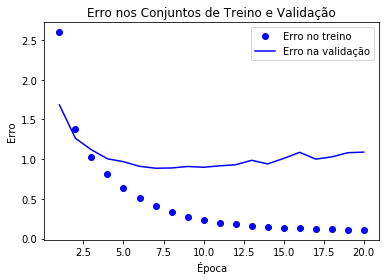

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Erro no treino')
plt.plot(epochs, val_loss, 'b', label='Erro na validação')
plt.title('Erro nos Conjuntos de Treino e Validação')
plt.xlabel('Época')
plt.ylabel('Erro')
plt.legend()

plt.show()

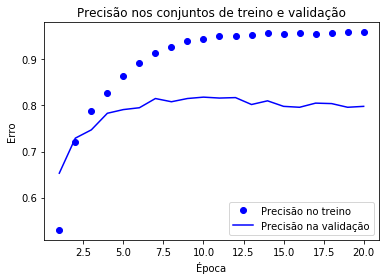

In [22]:
plt.clf()   
acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(epochs, acc, 'bo', label='Precisão no treino')
plt.plot(epochs, val_acc, 'b', label='Precisão na validação')
plt.title('Precisão nos conjuntos de treino e validação')
plt.xlabel('Época')
plt.ylabel('Erro')
plt.legend()

plt.show()

Os gráficos apontam para um overfitting a partir de 8 épocas de treino. Sendo assim, vamos treinar a rede em um total de 8 épocas e em seguida avaliar os resultados no conjunto de teste.

In [23]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(partial_x_train,
          partial_y_train,
          epochs=8,
          batch_size=512,
          validation_data=(x_val, y_val))
results = model.evaluate(x_test, one_hot_test_labels)

Train on 7982 samples, validate on 1000 samples
Epoch 1/8
7982/7982 [==============================] - 1s 75us/step - loss: 2.7063 - acc: 0.4941 - val_loss: 1.7931 - val_acc: 0.6640
Epoch 2/8
7982/7982 [==============================] - 0s 52us/step - loss: 1.4223 - acc: 0.7103 - val_loss: 1.3471 - val_acc: 0.7210
Epoch 3/8
7982/7982 [==============================] - 0s 53us/step - loss: 1.0395 - acc: 0.7814 - val_loss: 1.1368 - val_acc: 0.7500
Epoch 4/8
7982/7982 [==============================] - 0s 53us/step - loss: 0.8157 - acc: 0.8250 - val_loss: 1.0406 - val_acc: 0.7770
Epoch 5/8
7982/7982 [==============================] - 0s 52us/step - loss: 0.6469 - acc: 0.8623 - val_loss: 0.9847 - val_acc: 0.7910
Epoch 6/8
7982/7982 [==============================] - 0s 53us/step - loss: 0.5184 - acc: 0.8906 - val_loss: 0.9266 - val_acc: 0.8030
Epoch 7/8
7982/7982 [==============================] - 0s 52us/step - loss: 0.4106 - acc: 0.9138 - val_loss: 0.8895 - val_acc: 0.8140
Epoch 8/8
2246

In [24]:
results

[0.9755353522109645, 0.7894033838199487]

Obtivemos um resultado de ~78% de acertos. Isto significa que classificamos erroneamente ~19% dos casos. Em um sistema completamente ao acaso, com duas categorias o "0" seria escolhido em 50% das vezes. Sendo assim, os resultados são promissores quando comparados com um sistema de escolha aleatória.

In [25]:
import copy

test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
float(np.sum(np.array(test_labels) == np.array(test_labels_copy))) / len(test_labels)

0.1798753339269813

### Gerando previsões a partir de novos conjuntos de dados

Para tal utilizaremos o método ```.predict``` dos objetos tipo ```model``` da biblioteca keras

In [0]:
predictions = model.predict(x_test)

Cada entrada em ```predictions``` é um vetor com 46 posições, cada uma delas com a probabilidade da notícia pertencer a cada um dos tópicos. A soma das entradas em ```predictions``` será portanto igual a 1. A maior entrada em predictions é a classe prevista.

In [0]:
predictions[0].shape, np.sum(predictions[0]), np.argmax(predictions[0])

((46,), 1.0, 3)

## Uma forma distinta de formatar os vetores de entrada e a função de erro

Outra forma seria utilizar os tensores com números inteiros ao invés da formatação do tipo *one hot encoder*. Para tal a função de erro deverá ser do tipo *sparse_categorical_crossentropy*

In [0]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)
y_train

array([ 3,  4,  3, ..., 25,  3, 25])

In [0]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

## A importância de ter camadas com quantidade suficiente de neurons

No exemplo a seguir poderemos observar o efeito de criar um gargalo "informacional" em uma das camadas intermediárias, onde teremos apenas 4 neurons. Neste caso o desempenho da rede terá um teto de aprox.70%.

In [26]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=128,
          validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 1s 96us/step - loss: 3.2409 - acc: 0.3787 - val_loss: 2.7257 - val_acc: 0.5380
Epoch 2/20
7982/7982 [==============================] - 0s 59us/step - loss: 2.4039 - acc: 0.5517 - val_loss: 2.3063 - val_acc: 0.5680
Epoch 3/20
7982/7982 [==============================] - 0s 60us/step - loss: 2.1050 - acc: 0.5739 - val_loss: 2.1692 - val_acc: 0.5460
Epoch 4/20
7982/7982 [==============================] - 0s 61us/step - loss: 1.9375 - acc: 0.5985 - val_loss: 2.0833 - val_acc: 0.5460
Epoch 5/20
7982/7982 [==============================] - 0s 59us/step - loss: 1.8020 - acc: 0.5774 - val_loss: 1.9993 - val_acc: 0.5280
Epoch 6/20
7982/7982 [==============================] - 0s 60us/step - loss: 1.6467 - acc: 0.5412 - val_loss: 1.8947 - val_acc: 0.5080
Epoch 7/20
7982/7982 [==============================] - 0s 60us/step - loss: 1.4414 - acc: 0.5603 - val_loss: 1.6693 - val_acc: 0.5380
Epoch 8

## Conclusões

* Ao classificar um conjunto de pontos com N categorias, o último nível de ser do tipo ```Dense```com N neurons.
* Se o sistema for do tipo multi categoria com um único rótulo por registro a rede deverá terminar com a função de ativação do tipo `softmax` 
* Em problemas de classificação a função de erro mais comum é a *Categorical crossentropy* 
* Os rótulos por sua vez podem ser formatados de duas formas: 
    * "one hot encoding" com função de erro do tipo `categorical_crossentropy`
    * como números inteiros com função de erro `sparse_categorical_crossentropy`.
* Caso existam muitas categorias deve-se evitar a criação de gargalos informacionais, mantendo todos os níveis intermediários com um número de neurons pelo menos igual ao número de categorias.

## Exercícios

* Partindo da rede neural desenvolvida neste exercício, determine de forma gráfica o número de épocas de treino necessárias para que o erro no conjunto de validação iguale o erro no conjunto de treino, o valor do erro em si e a precisão obtida no conjunto de teste para as seguintes situações:
      1. 1 camada intermediária com 32 neurons
      2. 2 camadas intermediárias com 32 neurons
      3. 3 camadas intermediárias com 32 neurons
      4. 1 camada intermediária com 128 neurons
      5. 2 camadas intermediárias com 128 neurons
      6. 3 camadas intermediárias com 128 neurons

* Explique porque foi utilizada como função de ativação no nível de saida a função `softmax`

* Para uma amostra em específica de dados de entrada apresentada à rede neural, qual o significado dos valores nos dez neurons do nível de saida? Quanto deve ser a soma dos mesmos? Por quê? Como é executada a previsão de categoria de classificação neste caso?

* No caso do nível de saida com a função sigmóide, o que representa o valor de saida? Como pode neste caso ser executada a previsão de categoria?

* Defina o conceito de "gargalo informacional" ("information bottleneck") em uma rede neural. Quais os possíveis efeitos do mesmo.

* Por que neste exemplo a função de erro mais indicada é a `categorical_crossentropy` e não a "root mean square"?